In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard,ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
import tensorflow as tf
from keras.callbacks import Callback

import copy
import matplotlib.pyplot as plt


from tensorflow.keras.regularizers import l1, l2

from tqdm import tqdm

import numpy as np
import cv2
# import mediapipe as mp
from IPython.display import clear_output
from sklearn.model_selection import train_test_split

# from tensorflow_model_optimization.quantization.keras import quantize_model
from collections import Counter
import random as rand
import os

In [ ]:
import numpy as np

def txt_pre_process(txt_file,label,simplify=False,simplify_level=14 ):
    label_array = []
    temp_feature_data = []
    temp_sequence_data = []
    batch_data = []

    with open(str(txt_file), 'r') as file:

        for line in file:
            values = line.strip().split('|')

            temp_feature_data = []

            for value in values:
                float_value = str(value)

                #FIRST PART OF THE SEQUENCE
                if float_value == 'START':
                    temp_sequence_data=[]

                elif float_value == 'END':
                    batch_data.append(temp_sequence_data)
                    label_array.append(label)


                elif float_value != '' and float_value != 'START':
                    if simplify:
                        float_value = round(float(value),simplify_level)
                    else:
                        float_value = float(value)
                    temp_feature_data.append(float_value)

            if temp_feature_data!=[]:
                temp_sequence_data.append(temp_feature_data)

    label_array = np.array(label_array)
    return [batch_data,label_array]

#--------------------------------------------------------------------------- paddingV1 --------------------------------------------------------------------------------
# padding can be improved probably...by using sequence
# minor issue:
# > is whether sequences had exceeded the intended number of sequences but is still right (it was performed right but slower(by an acceptable margin)) - not resolved
#    = temporary fix was just to truncate everything if it had exceeded the intended number of sequence for the sake of running it for now
#    = a reliable solution in theory could be that to randomly truncate in between the first and end sequence, in this way relevant data can be captured
def padding(pre_processed_input,optional_maxLength=0):
    padded_sequences = []
    if optional_maxLength != 0:
        max_length = optional_maxLength
    else:
        max_length = max(len(sequence) for sequence in pre_processed_input)

    for sequence in pre_processed_input:
        padding_length = max_length - len(sequence)
        if padding_length >= 0:
            padded_sequence = np.pad(sequence, ((0, padding_length), (0, 0)), mode='constant')

        else:
            padded_sequence = sequence[:max_length]
        padded_sequences.append(padded_sequence)
    padded_sequences = np.array(padded_sequences)

    return padded_sequences

#--------------------------------------------------------------------------- paddingV1 --------------------------------------------------------------------------------

# this is to merge correct executions and wrong executions and randomize their input and label
# positions of input and its corresponding label are the same
# introducing noise/wrong input makes the model more robust
def concatenate_randomize_batches(base_input,base_label,concat_input,concat_label):
    combined_inputs = np.concatenate((base_input,concat_input), axis = 0)
    combined_label = np.concatenate((base_label,concat_label), axis = 0)
    indices = np.random.permutation(len(combined_inputs))
    randomized_inputs = combined_inputs[indices]
    randomized_label = combined_label[indices]
    return [randomized_inputs,randomized_label]




def tally_sequence(sequence_array):
    tally_number = []
    tally_ctr = []

    for x in sequence_array:
        temp = len(x)
        if temp not in tally_number:
            tally_number.append(temp)
            tally_ctr.append(1)
        else:
            for y in range(len(tally_number)) :
                if temp == tally_number[y]:
                    tally_ctr[y] = tally_ctr[y] + 1

    tally_max = 0
    tally_number_arranged = []
    tally_ctr_arranged = []

    for x in range(len(tally_number)):
        # print(len(tally_ctr))
        tally_max = max(tally_ctr)
        for y in range(len(tally_number)):
            if tally_ctr[y] == tally_max:
                tally_number_arranged.append(tally_number[y])
                tally_ctr_arranged.append(tally_ctr[y])
                tally_ctr.pop(y)
                tally_number.pop(y)
                break

    total_ctr = 0
    for x in tally_ctr:
        total_ctr = total_ctr + x


    for x in range(len(tally_number_arranged)):
        print(tally_number_arranged[x],'-->',tally_ctr_arranged[x])


# outlier detection and removal (currently being used)
def common_length_sequence(sequences_array,threshold = 2):
    temp = []

    data = [len(seq) for seq in sequences_array]
    data_frequency = Counter(data)
    most_common_data = data_frequency.most_common()
    outlier_frequencies = [value for value, freq in data_frequency.items() if freq < threshold]
    most_common_values = [value for value, freq in most_common_data if freq >= threshold]

    print("Most Common Data Points:", most_common_values)
    print("Outlier Frequencies:", outlier_frequencies)

    for x in sequences_array:
        if len(x) in most_common_values:
            temp.append(x)
    print('-------------------applied frequency outlier detection-------------------')
    print("original num -> ", len(sequences_array))
    print("current num -> ", len(temp))
    print("removed num -> ", len(sequences_array) - len(temp))
    return temp

# outlier detection and removal (currently being used)
def apply_z_score(sequences_array,z_score_threshold = 1):
    data_points = []
    included_datapoints = []
    updated_sequences =[]

    for x in sequences_array:
        temp = len(x)
        if temp not in data_points:
            data_points.append(temp)

    data = np.array(data_points)
    mean_value = np.mean(data)
    standard_deviation = np.std(data)
    z_scores = (data - mean_value) / standard_deviation
    for x in range(len(z_scores)):
        if np.abs(z_scores[x]) <= z_score_threshold:
            included_datapoints.append(data[x])


    for x in sequences_array:
        if len(x) in included_datapoints:
            updated_sequences.append(x)
    print('-------------------applied z-score outlier detection-------------------')
    print("datapoints included -> ", included_datapoints)
    print("original num -> ", len(sequences_array))
    print("current num -> ", len(updated_sequences))
    print("removed num -> ", len(sequences_array) - len(updated_sequences))

    return updated_sequences




def paddingV2(sequences_array_input,optional_maxlength = 0):
    sequences_array = copy.deepcopy(sequences_array_input)


    output = []
    max_length = 0
    if optional_maxlength == 0:
        max_length = max(len(sequence) for sequence in sequences_array)
        expanded_max_length = int(max_length+ ((max_length) * .10))
    else:
        expanded_max_length = optional_maxlength

    # sequence = np.array(sequences_array)

    print(expanded_max_length)


    padding_length_before = 0
    padding_length_after = 0

    for seq in sequences_array:
        # print(seq)
        for x in range(expanded_max_length-len(seq)+1):
            padding_length_before = x
            padding_length_after = expanded_max_length - len(seq) - x
            padded_sequence = np.pad(seq, ((padding_length_before, padding_length_after),(0,0)), mode='constant')
            output.append(padded_sequence)

            # print(padded_sequence)
    print('------------------------applied paddingV2------------------------')
    print('max_length -> ', max_length)
    print('expanded_max_length -> ', expanded_max_length)
    print('original num set of sequences -> ', len(sequences_array))
    print('final num set of sequences -> ', len(output))

    output = np.array(output)
    return output




def convert_tf_to_tflite(tf_model,input_shape,test_dataset,name,id_number,validation_loss,validation_accuracy):
  model = tf.keras.models.load_model(tf_model)

  run_model = tf.function(lambda x: model(x))
  # This is important, let's fix the input size.
  BATCH_SIZE = input_shape[0]
  STEPS = input_shape[1]
  INPUT_SIZE = input_shape[2]
  concrete_func = run_model.get_concrete_function(
      tf.TensorSpec([BATCH_SIZE, STEPS, INPUT_SIZE], model.inputs[0].dtype))

  # model directory.
  MODEL_DIR = "keras_lstm"
  model.save(MODEL_DIR, save_format="tf", signatures=concrete_func)

  converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_DIR)
  tflite_model = converter.convert()


  # Run the model with TensorFlow to get expected results.
  TEST_CASES = 10

  # Run the model with TensorFlow Lite
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()

  for i in range(TEST_CASES):
    expected = model.predict(test_dataset[i:i+1])
    interpreter.set_tensor(input_details[0]["index"], test_dataset[i:i+1, :, :])
    interpreter.invoke()
    result = interpreter.get_tensor(output_details[0]["index"])

    # Assert if the result of TFLite model is consistent with the TF model.
    np.testing.assert_almost_equal(expected, result, decimal=5)
    print("Done. The result of TensorFlow matches the result of TensorFlow Lite.")

    interpreter.reset_all_variables()



  temp = 'converted_model_'

  temp3 = temp + str(name) + id_number + "(loss_"+ str(round(validation_loss,3)) +")" + "(acc_"+  str(round(validation_accuracy,3 )) + ")" + '.tflite'
  # Save the TFLite model to a file
  with open(temp3, "wb") as f:
    f.write(tflite_model)
  # with open("converted_model.tflite", "wb") as f:
  #     f.write(tflite_model)


# this data augmentation replaces padded index with random inputs
def populate_0_input(correct_data_input,noise_data_input):
    correct_data = copy.deepcopy(correct_data_input)
    noise_data = copy.deepcopy(noise_data_input)

    print(len(correct_data))
    index = 10
    temp = []
    temp_compilation = []
    ctr = 0
    rand_modifier =0

    for set_sequence in tqdm(correct_data, desc="populate_0_input", leave=True):
        rand_modifier = rand.randint(0,len(noise_data))

        for x in range(len(set_sequence)):
            ctr = ctr + 1
            if set_sequence[x][0] == 0:
                temp.append(noise_data[rand_modifier-1][rand.randint(0,len(noise_data[rand_modifier-1])-1)])

            else:
                temp.append(set_sequence[x])

        temp_compilation.append(temp)
        temp =[]


    return temp_compilation



class CustomEarlyStopping(Callback):
  def __init__(self, accuracy_threshold=0.95, loss_threshold=0.10):
      super(CustomEarlyStopping, self).__init__()
      self.accuracy_threshold = accuracy_threshold
      self.loss_threshold = loss_threshold

  def on_epoch_end(self, epoch, logs=None):
      if logs is None:
          logs = {}

      if logs.get('val_accuracy') is None or logs.get('val_loss') is None:
          return

      if logs.get('val_accuracy') >= self.accuracy_threshold and logs.get('val_loss') <= self.loss_threshold:
          self.model.stop_training = True
          print(f"\nTraining stopped as validation accuracy reached {logs.get('val_accuracy'):.4f} "
                f"and validation loss reached {logs.get('val_loss'):.4f}")




class CustomEarlyStoppingV2(Callback):
    def __init__(self, accuracy_threshold=0.95, loss_threshold=0.10, patience=None):
        super(CustomEarlyStopping, self).__init__()
        self.accuracy_threshold = accuracy_threshold
        self.loss_threshold = loss_threshold
        self.patience = patience
        self.wait = 0  # Counter for patience

    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}

        if logs.get('val_accuracy') is None or logs.get('val_loss') is None:
            return

        if logs.get('val_accuracy') >= self.accuracy_threshold and logs.get('val_loss') <= self.loss_threshold:
            self.model.stop_training = True
            print(f"\nTraining stopped as validation accuracy reached {logs.get('val_accuracy'):.4f} "
                  f"and validation loss reached {logs.get('val_loss'):.4f}")
        else:
            if self.patience is not None and self.patience > 0:
                current_val_loss = logs.get('val_loss')
                if current_val_loss is not None:
                    if current_val_loss < self.best:
                        self.best = current_val_loss
                        self.wait = 0
                    else:
                        self.wait += 1
                        if self.wait >= self.patience:
                            self.model.stop_training = True
                            print(f"\nTraining stopped due to lack of improvement for {self.patience} epochs.")
                            self.restore_best_weights()

# this data augmentation augments data to simulate if the sequence were follow,whether there is unecessary movements in between.
# this would also reinforce the model to detect certain action that were classified as correct instead of incorrect
# this augmentation is augmenting each sequence of a list of sequence
# 1 set of sequence(example-> 1 push up):
# [seq1,seq2,seq3,seq4]
# [seq1,seq2,NOISE_SEQ34,seq4]
def data_aug_sensitivity(sequence_array_list_input,noise_sequence_list_input,num_data_aug = 3,num_aug_in_1_seq = 3,noise_seq_len = 2):
  sequence_array_list = copy.deepcopy(sequence_array_list_input)
  noise_sequence_list = copy.deepcopy(noise_sequence_list_input)

  compile = []
  temp_seq = []
  temp_storage = []
  temp_rand = []
  num = 0
  ctr1111 = 0
  temp_rand2 = 0
  temp_rand3 = 0

# per sequences
  for sequence in tqdm(sequence_array_list, desc="data_aug_seq_sensitivity", leave=True):
    # loops for the number of data augmentation per sequence
    for ctr in range(num_data_aug):
      # loops for the amount of number of augmentation in the sequence(loops to get random index)
      while len(temp_rand)!=num_aug_in_1_seq:
        num = rand.randint(0,len(sequence)-1)
        if num in temp_rand:
          continue
        else:
          temp_rand.append(num)

      #actual augmentation of the sequence
      temp_seq = sequence.copy()
      # store in a temp variable and to be edited

      # number of augmentation to be done in a sequence
      for ctr1 in range(len(temp_rand)):

        # number of sequence to be expanded(index + number of noise_seq_len)
        for ctr2 in range(noise_seq_len):
          temp_rand2 = rand.randint(0,len(noise_sequence_list)-1)
          temp_rand3 = rand.randint(0,len(noise_sequence_list[0])-1)

          if (temp_rand[ctr1] + ctr2) < len(temp_seq):
            temp_seq[temp_rand[ctr1] + ctr2] = noise_sequence_list[temp_rand2][temp_rand3]


          else:
            continue


      compile.append(temp_seq)
      temp_seq = []
      temp_rand = []


  return compile


def data_aug_seq_sensitivity(sequence_array_list_input,num_to_aug=2,num_coor_edit=3,num_sequence_edit=2):
  sequence_array_list = copy.deepcopy(sequence_array_list_input)

  compile = []
  temp = []
  rand_coor = []


  for ctr in tqdm(range(num_to_aug), desc="data_aug_coor_sensitivity", leave=True):
    for sequence in sequence_array_list:
      for ctr3 in range(num_sequence_edit):
        what_sequence = rand.randint(0,len(sequence)-1)
        for ctr2 in range(num_coor_edit):
          what_coor = rand.randint(0,len(sequence[0])-1)
          rand_coor = rand.randint(0,9999999999)
          rand_coor = rand_coor / (10 ** len(str(rand_coor)))
          sequence[what_sequence][what_coor]=rand_coor
      compile.append(sequence)
  return compile


def data_aug_coor_sensitivity(sequence_array_list_input,num_coor_edit=45,num_sequence_edit=8):
  sequence_array_list = copy.deepcopy(sequence_array_list_input)

  compile = []
  temp = []
  rand_coor = []
  temp_seq = []



  # for ctr in tqdm(range(num_to_aug), desc="data_aug_coor_sensitivity", leave=True):
  for sequence in sequence_array_list:
    temp_seq = sequence.copy()
    for ctr3 in range(num_sequence_edit):
      what_sequence = rand.randint(0,len(sequence)-1)
      num_coor_edit = rand.randint(int(num_coor_edit*.65),num_coor_edit)
      for ctr2 in range(num_coor_edit):
        what_coor = rand.randint(0,len(sequence[0])-1)
        # rand_coor = rand.randint(0,9999999999)
        rand_coor = rand.randint(0,999)
        rand_coor = rand_coor / (10 ** len(str(rand_coor)))
        temp_seq[what_sequence][what_coor]=rand_coor
    compile.append(sequence)
  return compile





def plot_training_history(history):
    epochs = range(1, len(history.history['loss']) + 1)

    # Plotting training and validation loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# ... (your existing code)

# After the training loop
# plot_training_history(history)


# coordinate adversary sensetivity1
# augments data to make model more acceptable to flaws
def coorAdvSens1(sequence_array_list_input,num_aug = 5,sensetivity = 0.3):
  sequence_array_list = copy.deepcopy(sequence_array_list_input)

  tempExecution = []
  tempSequence = []
  tempFinalList = []
  temp = 0


  for ctr in range(num_aug):
    for execution in tqdm(sequence_array_list_input[0], desc="coorAdvSens1", leave=True):
      for sequence in execution:
        for individual_coor in sequence:
          temp =  round(rand.uniform(individual_coor - sensetivity, individual_coor + sensetivity), 8)
          tempSequence.append(temp)
        tempExecution.append(tempSequence)
        print(len(tempExecution))
        temp = []
      tempFinalList.append(tempExecution)
      tempExecution = []

  return tempFinalList







# coordinate adversary sensetivity1
# augments correct data to make it slighlt different to the point it is considered incorrect
# def coorAdvSens2(sequence_array_list_input,num_aug = 5,sensetivity = 0.4):















In [ ]:
temp = txt_pre_process('/content/drive/MyDrive/Colab Notebooks/coordinatesCollected(01-06-24----1203).txt',1,False,4)
coorAdvSens1(temp)

In [ ]:

# 0 1  -> 0
# 2 3  -> 1
# 4 5  -> 2
# 6 7  -> 3
# 8 9  -> 4
# 10 11  -> 5
# 12 13  -> 6
# 14 15  -> 7
# 16 17  -> 8
# 18 19  -> 9
# 20 21  -> 10
# 22 23  -> 11
# 24 25  -> 12
# 26 27  -> 13
# 28 29  -> 14
# 30 31  -> 15
# 32 33  -> 16
# 34 35  -> 17
# 36 37  -> 18
# 38 39  -> 19
# 40 41  -> 20
# 42 43  -> 21
# 44 45  -> 22
# 46 47  -> 23
# 48 49  -> 24
# 50 51  -> 25
# 52 53  -> 26
# 54 55  -> 27
# 56 57  -> 28
# 58 59  -> 29
# 60 61  -> 30
# 62 63  -> 31
# 64 65  -> 32

# # ----------------------------------------------------------------------------
#   left_upper_arm_sequence = []
#   left_lower_arm_sequence = []
#   left_hand_sequence = []

#   right_upper_arm_sequence = []
#   right_lower_arm_sequence = []
#   right_hand_sequence = []

#   left_upper_leg_sequence = []
#   left_lower_leg_sequence = []
#   left_feet_sequence = []

#   right_upper_leg_sequence = []
#   right_lower_leg_sequence = []
#   right_feet_sequence = []

#   body_sequence = []
#   head_sequence = []

#   # ------------------------------------------------------------------------------
#   left_upper_arm_sequence_noise = []
#   left_lower_arm_sequence_noise = []
#   left_hand_sequence_noise = []

#   right_upper_arm_sequence_noise = []
#   right_lower_arm_sequence_noise = []
#   right_hand_sequence_noise = []

#   left_upper_leg_sequence_noise = []
#   left_lower_leg_sequence_noise = []
#   left_feet_sequence_noise = []

#   right_upper_leg_sequence_noise = []
#   right_lower_leg_sequence_noise = []
#   right_feet_sequence_noise = []

#   body_sequence_noise = []
#   head_sequence_noise = []




reinforce your noise/incorrect dataset by having correct data but with randomized index replaced with random sequence

in theory this would make the model more sensitive to changes

we may also add values unto the model to simulate certain movement going more than what is intended


----------------------------correct data augmentation ----------------------------
Most Common Data Points: [5, 4, 6, 7, 2]
Outlier Frequencies: [15]
-------------------applied frequency outlier detection-------------------
original num ->  79
current num ->  78
removed num ->  1
-------------------applied z-score outlier detection-------------------
datapoints included ->  [5, 4, 6]
original num ->  78
current num ->  73
removed num ->  5
6
------------------------applied paddingV2------------------------
max_length ->  6
expanded_max_length ->  6
original num set of sequences ->  73
final num set of sequences ->  149
concat ->  149

----------------------------data noise data augmentation ----------------------------
6
------------------------applied paddingV2------------------------
max_length ->  0
expanded_max_length ->  6
original num set of sequences ->  387
final num set of sequences ->  1138
1138


data_aug_seq_sensitivity: 100%|██████████| 149/149 [00:00<00:00, 4625.57it/s]


aug_noise_data5---> (1287, 6, 66)


Epoch 1/200
1/1 [==============================] - 17s 17s/step - loss: 0.6933 - accuracy: 0.5337 - val_loss: 0.6932 - val_accuracy: 0.4556
Epoch 2/200
1/1 [==============================] - 0s 136ms/step - loss: 0.6933 - accuracy: 0.5192 - val_loss: 0.6933 - val_accuracy: 0.4556
Epoch 3/200
1/1 [==============================] - 0s 148ms/step - loss: 0.6931 - accuracy: 0.5192 - val_loss: 0.6933 - val_accuracy: 0.4556
Epoch 4/200
1/1 [==============================] - 0s 134ms/step - loss: 0.6931 - accuracy: 0.5192 - val_loss: 0.6934 - val_accuracy: 0.4556
Epoch 5/200
1/1 [==============================] - 0s 130ms/step - loss: 0.6931 - accuracy: 0.5192 - val_loss: 0.6934 - val_accuracy: 0.4556
Epoch 6/200
1/1 [==============================] - 0s 143ms/step - loss: 0.6931 - accuracy: 0.5192 - val_loss: 0.6935 - val_accuracy: 0.4556
Epoch 7/200
1/1 [==============================] - 0s 150ms/step - loss: 0.6930 - accuracy: 0.5192 - val_loss: 0.6935 - val_accuracy: 0.4556
Epoch 8/200
1/

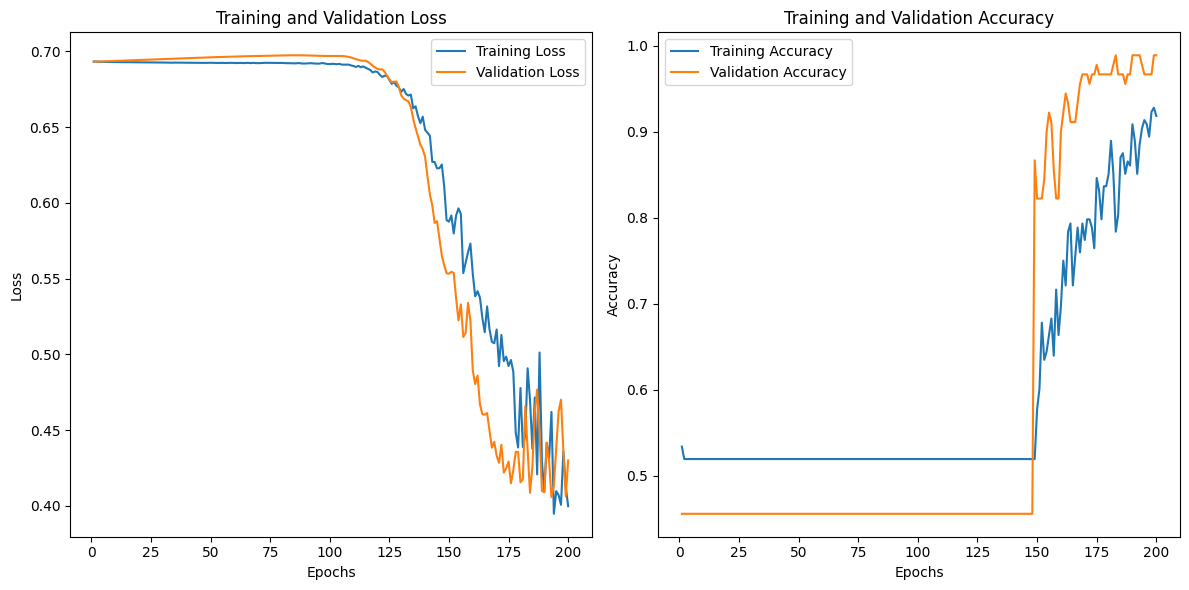

Epoch 1/200
1/1 [==============================] - 0s 318ms/step - loss: 0.4111 - accuracy: 0.9327 - val_loss: 0.3629 - val_accuracy: 1.0000
Epoch 2/200
1/1 [==============================] - 0s 277ms/step - loss: 0.4126 - accuracy: 0.9231 - val_loss: 0.3527 - val_accuracy: 1.0000
Epoch 3/200
1/1 [==============================] - 0s 305ms/step - loss: 0.3776 - accuracy: 0.9519 - val_loss: 0.3505 - val_accuracy: 1.0000
Epoch 4/200
1/1 [==============================] - 0s 283ms/step - loss: 0.3728 - accuracy: 0.9087 - val_loss: 0.3729 - val_accuracy: 0.9889
Epoch 5/200
1/1 [==============================] - 0s 272ms/step - loss: 0.3610 - accuracy: 0.9375 - val_loss: 0.4099 - val_accuracy: 0.9778
Epoch 6/200
1/1 [==============================] - 0s 306ms/step - loss: 0.3860 - accuracy: 0.9231 - val_loss: 0.4001 - val_accuracy: 0.9778
Epoch 7/200
1/1 [==============================] - 0s 213ms/step - loss: 0.3839 - accuracy: 0.9375 - val_loss: 0.3684 - val_accuracy: 0.9889
Epoch 8/200
1

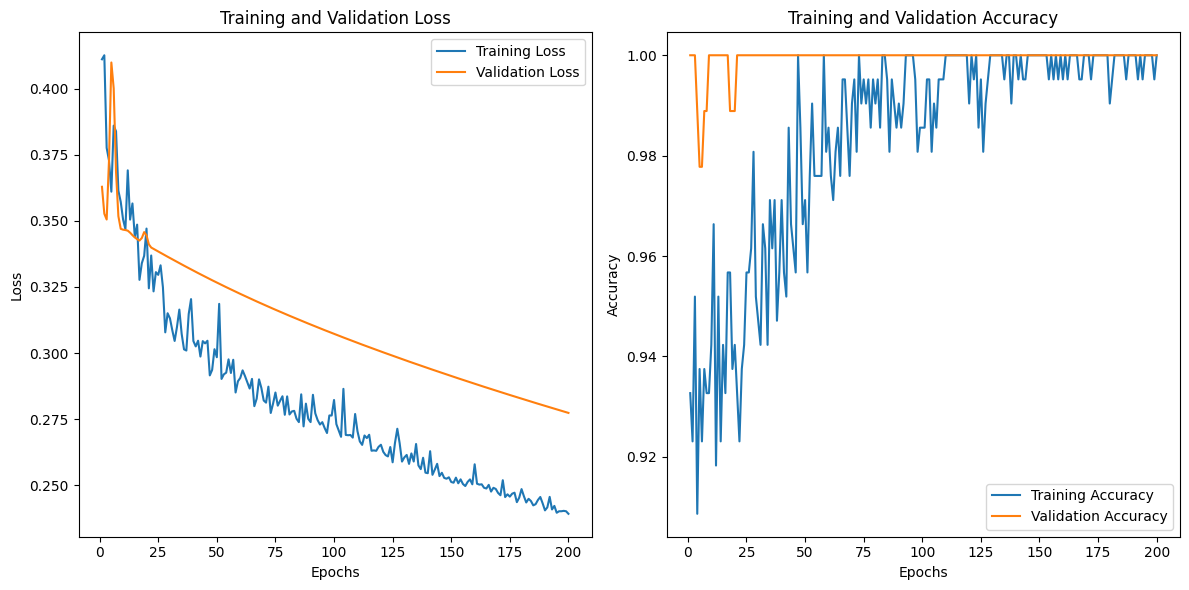

Epoch 1/200
1/1 [==============================] - 0s 188ms/step - loss: 0.2632 - accuracy: 1.0000 - val_loss: 0.2217 - val_accuracy: 1.0000
Epoch 2/200
1/1 [==============================] - 0s 181ms/step - loss: 0.2631 - accuracy: 1.0000 - val_loss: 0.2215 - val_accuracy: 1.0000
Epoch 3/200
1/1 [==============================] - 0s 149ms/step - loss: 0.2635 - accuracy: 1.0000 - val_loss: 0.2213 - val_accuracy: 1.0000
Epoch 4/200
1/1 [==============================] - 0s 148ms/step - loss: 0.2640 - accuracy: 1.0000 - val_loss: 0.2211 - val_accuracy: 1.0000
Epoch 5/200
1/1 [==============================] - 0s 153ms/step - loss: 0.2618 - accuracy: 1.0000 - val_loss: 0.2208 - val_accuracy: 1.0000
Epoch 6/200
1/1 [==============================] - 0s 133ms/step - loss: 0.2621 - accuracy: 1.0000 - val_loss: 0.2206 - val_accuracy: 1.0000
Epoch 7/200
1/1 [==============================] - 0s 162ms/step - loss: 0.2632 - accuracy: 1.0000 - val_loss: 0.2204 - val_accuracy: 1.0000
Epoch 8/200
1

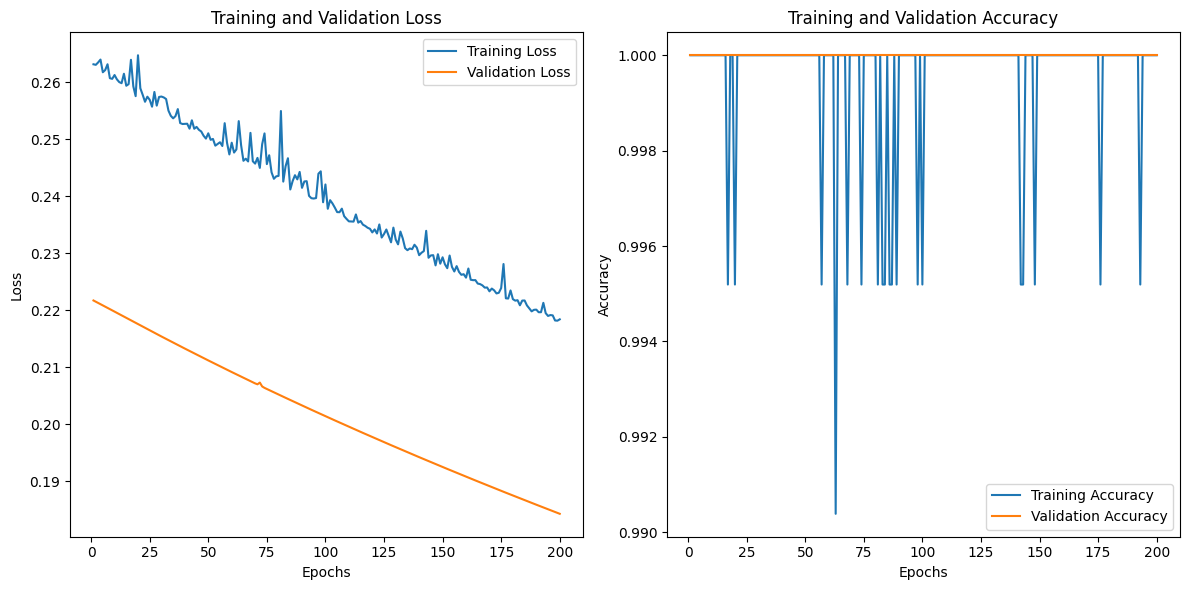

Epoch 1/200
1/1 [==============================] - 0s 197ms/step - loss: 0.2519 - accuracy: 1.0000 - val_loss: 0.2494 - val_accuracy: 1.0000
Epoch 2/200
1/1 [==============================] - 0s 156ms/step - loss: 0.2512 - accuracy: 1.0000 - val_loss: 0.2492 - val_accuracy: 1.0000
Epoch 3/200
1/1 [==============================] - 0s 153ms/step - loss: 0.2556 - accuracy: 0.9952 - val_loss: 0.2490 - val_accuracy: 1.0000
Epoch 4/200
1/1 [==============================] - 0s 143ms/step - loss: 0.2565 - accuracy: 0.9952 - val_loss: 0.2488 - val_accuracy: 1.0000
Epoch 5/200
1/1 [==============================] - 0s 140ms/step - loss: 0.2556 - accuracy: 0.9952 - val_loss: 0.2486 - val_accuracy: 1.0000
Epoch 6/200
1/1 [==============================] - 0s 147ms/step - loss: 0.2540 - accuracy: 0.9952 - val_loss: 0.2484 - val_accuracy: 1.0000
Epoch 7/200
1/1 [==============================] - 0s 168ms/step - loss: 0.2509 - accuracy: 1.0000 - val_loss: 0.2482 - val_accuracy: 1.0000
Epoch 8/200
1

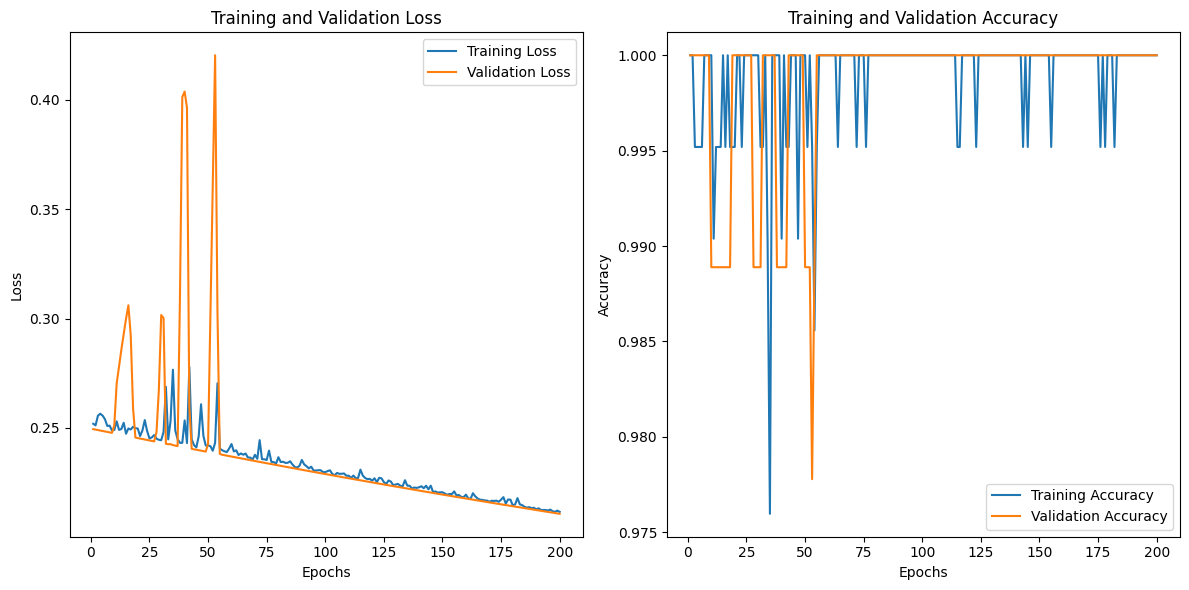

Epoch 1/200
1/1 [==============================] - 0s 185ms/step - loss: 0.2640 - accuracy: 0.9952 - val_loss: 0.2605 - val_accuracy: 1.0000
Epoch 2/200
1/1 [==============================] - 0s 145ms/step - loss: 0.2467 - accuracy: 1.0000 - val_loss: 0.2603 - val_accuracy: 1.0000
Epoch 3/200
1/1 [==============================] - 0s 139ms/step - loss: 0.2533 - accuracy: 0.9904 - val_loss: 0.2601 - val_accuracy: 1.0000
Epoch 4/200
1/1 [==============================] - 0s 152ms/step - loss: 0.2607 - accuracy: 0.9904 - val_loss: 0.2599 - val_accuracy: 1.0000
Epoch 5/200
1/1 [==============================] - 0s 141ms/step - loss: 0.2541 - accuracy: 1.0000 - val_loss: 0.2597 - val_accuracy: 1.0000
Epoch 6/200
1/1 [==============================] - 0s 164ms/step - loss: 0.2472 - accuracy: 1.0000 - val_loss: 0.2595 - val_accuracy: 1.0000
Epoch 7/200
1/1 [==============================] - 0s 162ms/step - loss: 0.2468 - accuracy: 0.9952 - val_loss: 0.2593 - val_accuracy: 1.0000
Epoch 8/200
1

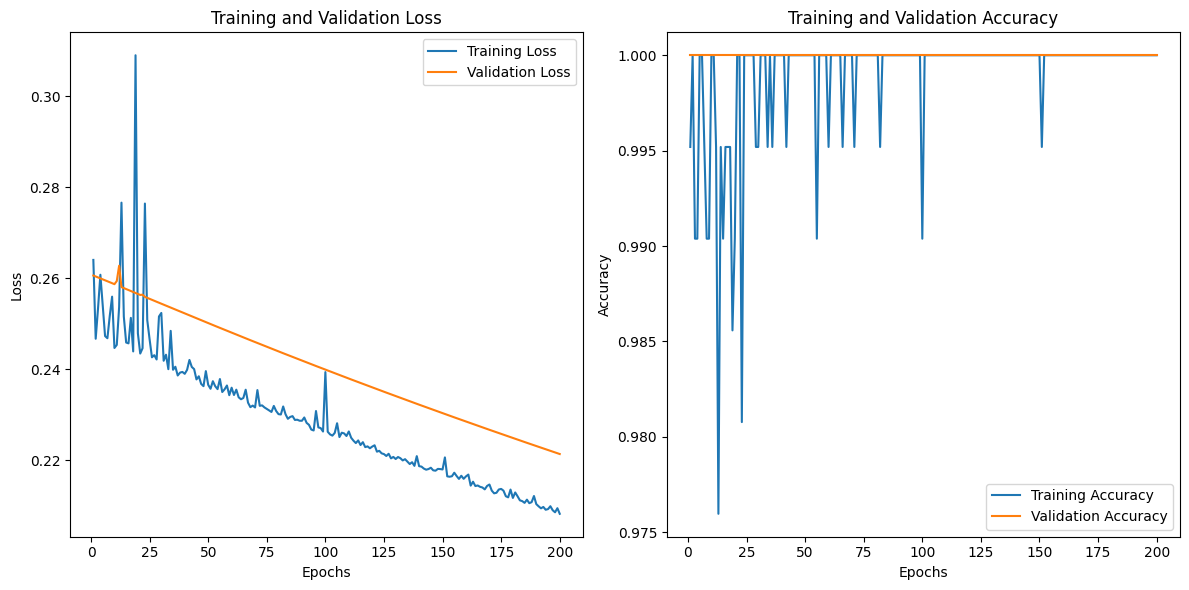

Epoch 1/200
1/1 [==============================] - 0s 270ms/step - loss: 0.2518 - accuracy: 1.0000 - val_loss: 0.2495 - val_accuracy: 1.0000
Epoch 2/200
1/1 [==============================] - 0s 271ms/step - loss: 0.2577 - accuracy: 0.9952 - val_loss: 0.2493 - val_accuracy: 1.0000
Epoch 3/200
1/1 [==============================] - 0s 159ms/step - loss: 0.2518 - accuracy: 1.0000 - val_loss: 0.2491 - val_accuracy: 1.0000
Epoch 4/200
1/1 [==============================] - 0s 158ms/step - loss: 0.2517 - accuracy: 1.0000 - val_loss: 0.2489 - val_accuracy: 1.0000
Epoch 5/200
1/1 [==============================] - 0s 162ms/step - loss: 0.2505 - accuracy: 0.9952 - val_loss: 0.2487 - val_accuracy: 1.0000
Epoch 6/200
1/1 [==============================] - 0s 162ms/step - loss: 0.2502 - accuracy: 1.0000 - val_loss: 0.2485 - val_accuracy: 1.0000
Epoch 7/200
1/1 [==============================] - 0s 146ms/step - loss: 0.2507 - accuracy: 1.0000 - val_loss: 0.2483 - val_accuracy: 1.0000
Epoch 8/200
1

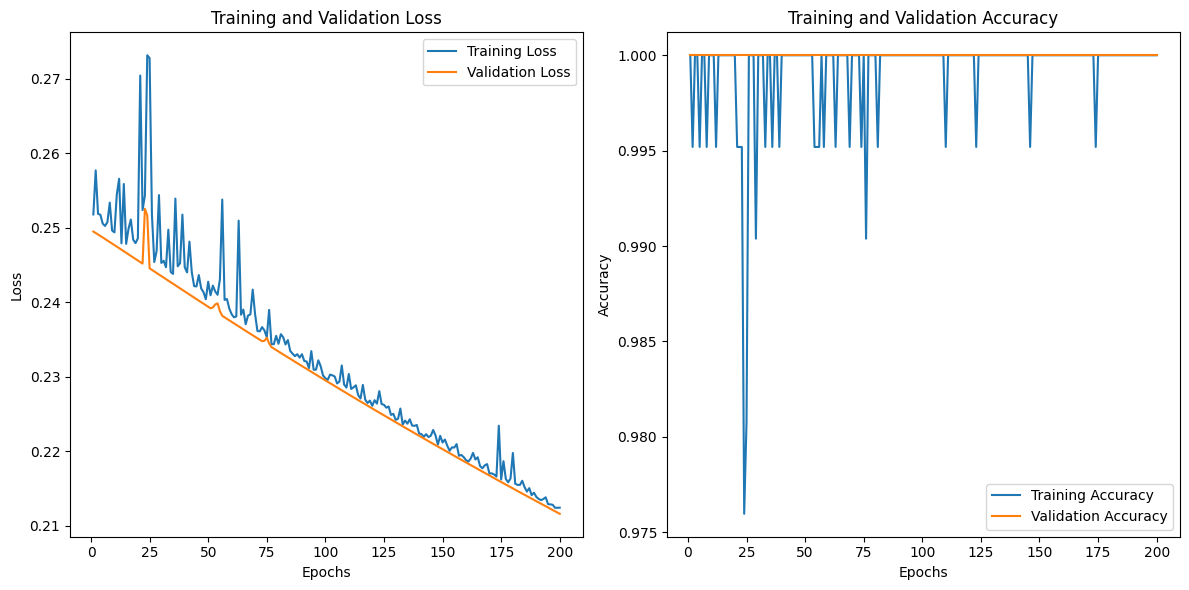

Epoch 1/200
1/1 [==============================] - 0s 355ms/step - loss: 0.2609 - accuracy: 1.0000 - val_loss: 0.2273 - val_accuracy: 1.0000
Epoch 2/200
1/1 [==============================] - 0s 303ms/step - loss: 0.2600 - accuracy: 1.0000 - val_loss: 0.2271 - val_accuracy: 1.0000
Epoch 3/200
1/1 [==============================] - 0s 347ms/step - loss: 0.2600 - accuracy: 1.0000 - val_loss: 0.2269 - val_accuracy: 1.0000
Epoch 4/200
1/1 [==============================] - 0s 301ms/step - loss: 0.2714 - accuracy: 0.9952 - val_loss: 0.2267 - val_accuracy: 1.0000
Epoch 5/200
1/1 [==============================] - 0s 246ms/step - loss: 0.2599 - accuracy: 1.0000 - val_loss: 0.2266 - val_accuracy: 1.0000
Epoch 6/200
1/1 [==============================] - 0s 309ms/step - loss: 0.2596 - accuracy: 1.0000 - val_loss: 0.2264 - val_accuracy: 1.0000
Epoch 7/200
1/1 [==============================] - 0s 337ms/step - loss: 0.2601 - accuracy: 1.0000 - val_loss: 0.2262 - val_accuracy: 1.0000
Epoch 8/200
1

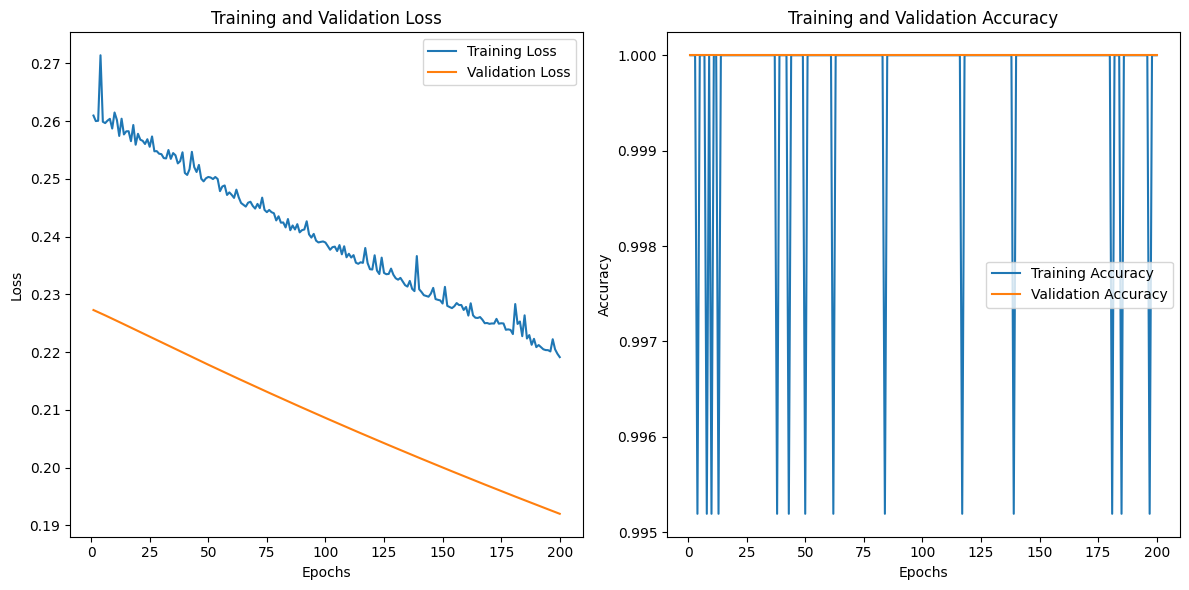

Epoch 1/200
1/1 [==============================] - 0s 206ms/step - loss: 0.2417 - accuracy: 1.0000 - val_loss: 0.2772 - val_accuracy: 1.0000
Epoch 2/200
1/1 [==============================] - 0s 161ms/step - loss: 0.2402 - accuracy: 0.9952 - val_loss: 0.2770 - val_accuracy: 1.0000
Epoch 3/200
1/1 [==============================] - 0s 158ms/step - loss: 0.2393 - accuracy: 1.0000 - val_loss: 0.2767 - val_accuracy: 1.0000
Epoch 4/200
1/1 [==============================] - 0s 163ms/step - loss: 0.2402 - accuracy: 1.0000 - val_loss: 0.2765 - val_accuracy: 1.0000
Epoch 5/200
1/1 [==============================] - 0s 155ms/step - loss: 0.2379 - accuracy: 1.0000 - val_loss: 0.2763 - val_accuracy: 1.0000
Epoch 6/200
1/1 [==============================] - 0s 164ms/step - loss: 0.2392 - accuracy: 1.0000 - val_loss: 0.2761 - val_accuracy: 1.0000
Epoch 7/200
1/1 [==============================] - 0s 175ms/step - loss: 0.2382 - accuracy: 1.0000 - val_loss: 0.2759 - val_accuracy: 1.0000
Epoch 8/200
1

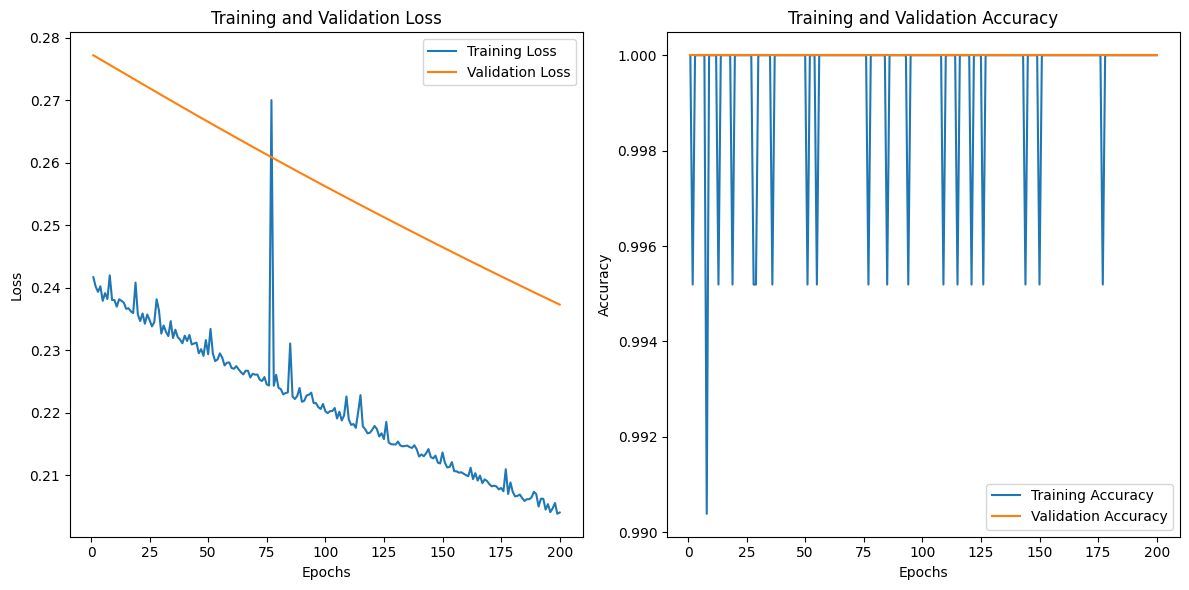

1/1 [==============================] - 1s 1s/step
Done. The result of TensorFlow matches the result of TensorFlow Lite.
1/1 [==============================] - 0s 26ms/step
Done. The result of TensorFlow matches the result of TensorFlow Lite.
1/1 [==============================] - 0s 27ms/step
Done. The result of TensorFlow matches the result of TensorFlow Lite.
1/1 [==============================] - 0s 27ms/step
Done. The result of TensorFlow matches the result of TensorFlow Lite.
1/1 [==============================] - 0s 28ms/step
Done. The result of TensorFlow matches the result of TensorFlow Lite.
1/1 [==============================] - 0s 57ms/step
Done. The result of TensorFlow matches the result of TensorFlow Lite.
1/1 [==============================] - 0s 58ms/step
Done. The result of TensorFlow matches the result of TensorFlow Lite.
1/1 [==============================] - 0s 50ms/step
Done. The result of TensorFlow matches the result of TensorFlow Lite.
1/1 [=====================

In [ ]:
# this is as a whole exercise
def streamlined_process(correct_execution,noise_data):
  id_num = str(rand.randint(1000,9999))
  base_data = txt_pre_process(correct_execution,1,False,4)
  base_data_noise = txt_pre_process(noise_data,0,False,4)

  loop = 0

  temp_correct_start=[]
  temp_correct_wrong=[]

  temp_wrong_store_train = []

  data = base_data[0]
  data_noise = base_data_noise[0]

  best_val_loss = float('inf')
  best_val_accuracy = 0.0
  best_model = None



  print('')
  print('----------------------------correct data augmentation ----------------------------')
  aug = common_length_sequence(data)
  aug2 = apply_z_score(aug,1)
  aug3 = paddingV2(aug2)


  # originial
        # aug4 = populate_0_input(aug3,data_noise)
        # aug4 = np.array(aug4)

  aug4 = np.array(aug3)

  aug4 = aug4.reshape(-1,len(aug3[0]),len(aug3[0][0]))
  combined_inputs = np.concatenate((aug4,aug3), axis = 0)
  combined_inputs = aug4
  print('concat -> ', len(combined_inputs))


  print('')
  print('----------------------------data noise data augmentation ----------------------------')
  aug_noise_data1 = paddingV2(data_noise,len(aug3[0]))
  aug_noise_data2 = populate_0_input(aug_noise_data1,data_noise)

# testing...
  # data_aug_coor_sensitivity()

# original
  # aug_noise_data3 = aug_noise_data2[0:len(combined_inputs)]

# testing(temporary)
  aug_noise_data3 = aug_noise_data2[:]

  aug_noise_data4 = np.array(aug_noise_data3)

  aug_noise_data5 = aug_noise_data4.reshape(-1,len(aug_noise_data4[0]),len(aug_noise_data4[0][0]))

# testing(temporary)
  # aug_noise_data7 = data_aug_coor_sensitivity(aug_noise_data5,num_sequence_edit=int(len(aug_noise_data5[0])*.70))


  aug_noise_data7 = data_aug_coor_sensitivity(aug_noise_data5,num_sequence_edit=int(len(aug_noise_data5[0])*.30))



  # aug_noise_data6 = data_aug_sensitivity(aug4,aug_noise_data5,1,2,2)
  aug_noise_data6 = data_aug_sensitivity(aug4,aug_noise_data5,1,2,int(len(combined_inputs)*.35))

# original
  aug_noise_data5 = np.concatenate((aug_noise_data6,aug_noise_data5), axis = 0)

# testing(temporary)
  # aug_noise_data5 = np.concatenate((aug_noise_data6,aug_noise_data5,aug_noise_data7), axis = 0)


  print('aug_noise_data5--->',aug_noise_data5.shape)


  loop = int(len(aug_noise_data5)/len(combined_inputs))

  model = Sequential()
  model.add(LSTM(len(aug4[0]), return_sequences=True, activation='relu',  input_shape=(len(aug4[0]), len(aug4[0][0]))))
  model.add(LSTM(len(aug4[0]) + int(len(aug4[0]) - int(len(aug4[0]) * .4)), return_sequences=True,  activation='relu'))
  model.add(Bidirectional(LSTM(len(aug4[0]) - int(len(aug4[0]) - int(len(aug4[0]) * .4)), return_sequences=True, dropout=0.3, recurrent_dropout=0.3, activation='relu')))
  model.add(Bidirectional(LSTM(len(aug4[0]) - int(len(aug4[0]) - int(len(aug4[0]) * .4)), return_sequences=True, dropout=0.65, recurrent_dropout=0.65, activation='relu')))

  # model.add(Bidirectional(LSTM(len(aug4[0]) - int(len(aug4[0]) - int(len(aug4[0]) * .4)), return_sequences=True, dropout=0.5, recurrent_dropout=0.5, activation='relu')))

  model.add(LSTM(len(aug4[0]) - int(len(aug4[0]) - int(len(aug4[0]) * .4)), return_sequences=False, activation='relu'))
  # model.add(BatchNormalization())
  model.add(Dense(len(aug4[0]) - int(len(aug4[0]) - int(len(aug4[0]) * .3)), activation='relu'))
  model.add(Dense(1,activation='sigmoid'))
  custom_early_stopping = CustomEarlyStopping(accuracy_threshold=0.97, loss_threshold=0.05)
  # custom_early_stopping = CustomEarlyStoppingV2(accuracy_threshold=0.95, loss_threshold=0.10, patience=5)
  model.compile(optimizer = 'Adam' , loss = 'binary_crossentropy', metrics=['accuracy'])




  for x in range(loop):
    temp_wrong_store_train = aug_noise_data5[x*len(combined_inputs):len(combined_inputs)*(x+1)]

    aug3_label = np.ones(len(combined_inputs))
    aug_noise_label = np.zeros(len(temp_wrong_store_train))

    rand_batches=concatenate_randomize_batches(combined_inputs,aug3_label,temp_wrong_store_train,aug_noise_label)

    X_train, X_test, y_train, y_test = train_test_split(rand_batches[0], rand_batches[1], test_size=0.3, random_state=42)

    # history=model.fit(X_train, y_train, epochs=200, batch_size =256  , validation_data=(X_test, y_test), callbacks=[custom_early_stopping])
    history=model.fit(X_train, y_train, epochs=200, batch_size =256  , validation_data=(X_test, y_test), callbacks=[custom_early_stopping])


    val_loss = min(history.history['val_loss'])
    val_accuracy = max(history.history['val_accuracy'])
    temp_wrong_store_train=[]


    if val_loss < best_val_loss and val_accuracy > best_val_accuracy:
      best_model = model.get_weights()
      best_val_loss = val_loss
      best_val_accuracy = val_accuracy

    # testing(temporary)
    model.set_weights(best_model)
    plot_training_history(history)



  X_train = X_train.astype(np.float32)
  X_test = X_test.astype(np.float32)
  model.save('testingModel')
  convert_tf_to_tflite('/content/testingModel',[1,len(aug3[0]),len(aug3[0][0])], X_test,'whole_model',id_num,val_loss,val_accuracy)











# uncomment this to run training model as a whole(this means that this model can determine the motion as a whole but not specify what part if correct or not)
# streamlined_process('/content/drive/MyDrive/Colab Notebooks/correct_new_2.txt','/content/drive/MyDrive/Colab Notebooks/wrong_new_2.txt')
streamlined_process('/content/drive/MyDrive/Colab Notebooks/coordinatesCollected(01-06-24----1203).txt','/content/drive/MyDrive/Colab Notebooks/firstExerciseFitguide(Wrong).txt')




In [ ]:
# this is for the individual models
# this is experimental
def streamlined_process(correct_execution,noise_data,loop=5):
  id_num = str(rand.randint(1000,9999))
  base_data = txt_pre_process(correct_execution,1,False,4)
  base_data_noise = txt_pre_process(noise_data,0,False,4)

  temp_correct_start=[]
  temp_correct_wrong=[]

  data = base_data[0]
  data_noise = base_data_noise[0]



  print('')
  print('----------------------------correct data augmentation ----------------------------')
  aug = common_length_sequence(data)
  aug2 = apply_z_score(aug,1)
  aug3 = paddingV2(aug2)
  aug4 = populate_0_input(aug3,data_noise)
  aug4 = np.array(aug4)
  aug4 = aug4.reshape(-1,len(aug3[0]),len(aug3[0][0]))
  combined_inputs = np.concatenate((aug4,aug3), axis = 0)
  combined_inputs= aug4
  print('concat -> ', len(combined_inputs))



  print('')
  print('----------------------------data noise data augmentation ----------------------------')
  aug_noise_data1 = paddingV2(data_noise,len(aug3[0]))
  aug_noise_data2 = populate_0_input(aug_noise_data1,data_noise)
  aug_noise_data3 = aug_noise_data2[0:len(combined_inputs)]
  aug_noise_data4 = np.array(aug_noise_data3)
  aug_noise_data5 = aug_noise_data4.reshape(-1,len(aug_noise_data4[0]),len(aug_noise_data4[0][0]))

  aug_noise_data6 = data_aug_sensitivity(aug4,aug_noise_data5,1,1,int(len(combined_inputs)*.35))
  aug_noise_data5 = np.concatenate((aug_noise_data6,aug_noise_data5), axis = 0)
  # aug_noise_data6 = data_aug_coor_sensitivity(aug4)
  # aug_noise_data5 = np.concatenate((aug_noise_data6,aug_noise_data5), axis = 0)


  correct_data_set = []
  noise_data_set = []
  rand_batches = []

  print('testtesttesttest=======>',len(aug_noise_data5))


  for x in range(14):
    correct_data_set.append([])
    noise_data_set.append([])
    rand_batches.append([])


  for exercise in combined_inputs:

    left_upper_arm = []
    left_lower_arm = []
    left_hand = []
    right_upper_arm = []
    right_lower_arm = []
    right_hand = []
    left_upper_leg = []
    left_lower_leg = []
    left_feet = []
    right_upper_leg = []
    right_lower_leg = []
    right_feet = []
    head =[]
    body = []



#------------------------ generating the correct input of certain part------------------------------
    for sequence in exercise:
      # 11,13
      left_upper_arm.append([sequence[22],sequence[23],sequence[26],sequence[27]])
      # 13,15
      left_lower_arm.append([sequence[26],sequence[27],sequence[30],sequence[31]])
      # 15,17,19,21
      left_hand.append([sequence[30],sequence[31],sequence[34],sequence[35],sequence[38],sequence[39],sequence[42],sequence[43]])

      # 12,14
      right_upper_arm.append([sequence[24],sequence[25],sequence[28],sequence[29]])
      # 14,16
      right_lower_arm.append([sequence[28],sequence[29],sequence[32],sequence[33]])
      # 16,18,20,22
      right_hand.append([sequence[32],sequence[33],sequence[36],sequence[37],sequence[40],sequence[41],sequence[44],sequence[45]])

      # 23,25
      left_upper_leg.append([sequence[46],sequence[47],sequence[50],sequence[51]])
      # 25,27
      left_lower_leg.append([sequence[50],sequence[51],sequence[54],sequence[55]])
      # 27,29,31
      left_feet.append([sequence[54],sequence[55],sequence[58],sequence[59],sequence[62],sequence[63]])

      # 24,26
      right_upper_leg.append([sequence[48],sequence[49],sequence[52],sequence[53]])
      # 26,28
      right_lower_leg.append([sequence[52],sequence[53],sequence[56],sequence[57]])
      # 28,30,32
      right_feet.append([sequence[56],sequence[57],sequence[60],sequence[61],sequence[64],sequence[65]])

      # 11,12,23,24
      body.append([sequence[22],sequence[23],sequence[24],sequence[25],sequence[46],sequence[47],sequence[48],sequence[49]])
      # 7,8,9,10
      head.append([sequence[14],sequence[15],sequence[16],sequence[17],sequence[18],sequence[19],sequence[20],sequence[21]])


    correct_data_set[0].append(left_upper_arm)
    correct_data_set[1].append(left_lower_arm)
    correct_data_set[2].append(left_hand)

    correct_data_set[3].append(right_upper_arm)
    correct_data_set[4].append(right_lower_arm)
    correct_data_set[5].append(right_hand)

    correct_data_set[6].append(left_upper_leg)
    correct_data_set[7].append(left_lower_leg)
    correct_data_set[8].append(left_feet)

    correct_data_set[9].append(right_upper_leg)
    correct_data_set[10].append(right_lower_leg)
    correct_data_set[11].append(right_feet)

    correct_data_set[12].append(body)
    correct_data_set[13].append(head)




  for x in range(len(correct_data_set)):
    correct_data_set[x] = np.array(correct_data_set[x])

  # for x in range(len(noise_data_set)):
  #   noise_data_set[x] = np.array(noise_data_set[x])

  print('len of correct data set ---->',len(correct_data_set[0]))
  print('len of noise data set ---->',len(noise_data_set[0]))

  correct_data_set_label = np.ones(len(combined_inputs))
  noise_data_set_label = np.zeros(len(aug_noise_data5))

  # for x in range(len(correct_data_set)):
  #   rand_batches[x]=concatenate_randomize_batches(correct_data_set[x],correct_data_set_label,noise_data_set[x],noise_data_set_label)



  loop = int(len(aug_noise_data5)/len(combined_inputs))


  data_set_name=['left_upper_arm','left_lower_arm','left_hand','right_upper_arm','right_lower_arm','right_hand','left_upper_leg','left_lower_leg','left_feet','right_upper_leg','right_lower_leg','right_feet','head','body']
  for x in range(len(data_set_name)-1):
    print('progress -> ',x,'/',len(data_set_name)-1)



    best_val_loss = float('inf')
    best_val_accuracy = 0.0
    best_model = None

    for y in range(loop):

      noise_data_set=[]


    #------------------------------ generating noise ---------------------------------------
      for exercise in aug_noise_data5[len(correct_data_set[x])*y:len(correct_data_set[x]) + (len(correct_data_set[x])*y)]:
      # for exercise in aug_noise_data5[0:450]:
        # print('batchin noise ->',len(correct_data_set[x])*y,'<==--==>',len(correct_data_set[x]) + (len(correct_data_set[x])*y))


        left_upper_arm = []
        left_lower_arm = []
        left_hand = []
        right_upper_arm = []
        right_lower_arm = []
        right_hand = []
        left_upper_leg = []
        left_lower_leg = []
        left_feet = []
        right_upper_leg = []
        right_lower_leg = []
        right_feet = []
        head =[]
        body = []



        for sequence in exercise:
          # 11,13
          # print(sequence[22])
          if x == 0:
            left_upper_arm.append([sequence[22],sequence[23],sequence[26],sequence[27]])
          # 13,15
          if x == 1:
            left_lower_arm.append([sequence[26],sequence[27],sequence[30],sequence[31]])
          # 15,17,19,21
          if x == 2:
            left_hand.append([sequence[30],sequence[31],sequence[34],sequence[35],sequence[38],sequence[39],sequence[42],sequence[43]])

          # 12,14
          if x == 3:
            right_upper_arm.append([sequence[24],sequence[25],sequence[28],sequence[29]])
          # 14,16
          if x == 4:
            right_lower_arm.append([sequence[28],sequence[29],sequence[32],sequence[33]])
          # 16,18,20,22
          if x == 5:
            right_hand.append([sequence[32],sequence[33],sequence[36],sequence[37],sequence[40],sequence[41],sequence[44],sequence[45]])

          # 23,25
          if x == 6:
            left_upper_leg.append([sequence[46],sequence[47],sequence[50],sequence[51]])
          # 25,27
          if x == 7:
            left_lower_leg.append([sequence[50],sequence[51],sequence[54],sequence[55]])
          # 27,29,31
          if x == 8:
            left_feet.append([sequence[54],sequence[55],sequence[58],sequence[59],sequence[62],sequence[63]])

          # 24,26
          if x == 9:
            right_upper_leg.append([sequence[48],sequence[49],sequence[52],sequence[53]])
          # 26,28
          if x == 10:
            right_lower_leg.append([sequence[52],sequence[53],sequence[56],sequence[57]])
          # 28,30,32
          if x == 11:
            right_feet.append([sequence[56],sequence[57],sequence[60],sequence[61],sequence[64],sequence[65]])

          # 11,12,23,24
          if x == 12:
            body.append([sequence[22],sequence[23],sequence[24],sequence[25],sequence[46],sequence[47],sequence[48],sequence[49]])
          # 7,8,9,10
          if x == 13:
            head.append([sequence[14],sequence[15],sequence[16],sequence[17],sequence[18],sequence[19],sequence[20],sequence[21]])

        if x == 0:
          noise_data_set.append(left_upper_arm)
        if x == 1:
          noise_data_set.append(left_lower_arm)
        if x == 2:
          noise_data_set.append(left_hand)

        if x == 3:
          noise_data_set.append(right_upper_arm)
        if x == 4:
          noise_data_set.append(right_lower_arm)
        if x == 5:
          noise_data_set.append(right_hand)

        if x == 6:
          noise_data_set.append(left_upper_leg)
        if x == 7:
          noise_data_set.append(left_lower_leg)
        if x == 8:
          noise_data_set.append(left_feet)


        if x == 9:
          noise_data_set.append(right_upper_leg)
        if x == 10:
          noise_data_set.append(right_lower_leg)
        if x == 11:
          noise_data_set.append(right_feet)


        if x == 12:
          noise_data_set.append(body)
        if x == 13:
          noise_data_set.append(head)

# ===================================================================================================================================================

      print('correct->',len(correct_data_set[x]),'  incorrect->',len(noise_data_set[x]))

      rand_batches=concatenate_randomize_batches(correct_data_set[x],correct_data_set_label,noise_data_set,noise_data_set_label)





      print('loop -> ',y,'/',loop)
      X_train, X_test, y_train, y_test = train_test_split(rand_batches[0], rand_batches[1], test_size=0.2, random_state=42)

      # history = model.fit(X_train[y*len(rand_batches[x][0]):len(rand_batches[x][0])*(y+1)], y_train[y*len(rand_batches[x][1]):len(rand_batches[x][1])*(y+1)], epochs=200, batch_size =128 , validation_data=(X_test[y*len(rand_batches[x][0]):len(rand_batches[x][0])*(y+1)], y_test[y*len(rand_batches[x][1]):len(rand_batches[x][1])*(y+1)]), callbacks=[custom_early_stopping])

      if y == 0:
        model_base_modifier = 10
        model = Sequential()
        model.add(LSTM(model_base_modifier+len(aug4[0]), return_sequences=True, activation='relu',  input_shape=(len(correct_data_set[x][0]), len(correct_data_set[x][0][0]))))
        model.add(LSTM(model_base_modifier+len(aug4[0]) + int(len(aug4[0]) - int(len(aug4[0]) * .4)), return_sequences=True,  activation='relu' ))
        model.add(Bidirectional(LSTM(model_base_modifier+len(aug4[0]) - int(len(aug4[0]) - int(len(aug4[0]) * .5)), return_sequences=True, dropout=0.4, recurrent_dropout=0.4, activation='relu')))
        model.add(LSTM(model_base_modifier+len(aug4[0]) - int(len(aug4[0]) - int(len(aug4[0]) * .4)), return_sequences=False,  activation='relu'))
        # model.add(BatchNormalization())
        model.add(Dense(model_base_modifier+len(aug4[0]) - int(len(aug4[0]) - int(len(aug4[0]) * .4)), activation='relu'))

        model.add(Dense(1,activation='sigmoid'))

        custom_early_stopping = CustomEarlyStopping(accuracy_threshold=0.97, loss_threshold=0.05)
        model.compile(optimizer = 'Adam' , loss = 'binary_crossentropy', metrics=['accuracy'])



      history = model.fit(X_train, y_train, epochs=150, batch_size =128 , validation_data=(X_test, y_test), callbacks=[custom_early_stopping])

      val_loss = min(history.history['val_loss'])
      val_accuracy = max(history.history['val_accuracy'])

      if val_loss < best_val_loss and val_accuracy > best_val_accuracy:
        best_model = model.get_weights()
        best_val_loss = val_loss
        best_val_accuracy = val_accuracy

      model.set_weights(best_model)



    model.save('testingModel')


    # X_train = X_train[x].astype(np.float32)
    # X_test = X_test[x].astype(np.float32)

    # convert_tf_to_tflite('/content/testingModel',[1,len(X_train[0]),len(X_train[0][0])], X_test,data_set_name[x],id_num,val_loss,val_accuracy)
    # convert_tf_to_tflite('/content/testingModel',[1,len(correct_data_set[x][0]),len(correct_data_set[x][0][0])], X_test,data_set_name[x],id_num,val_loss,val_accuracy)


    X_train = X_train.astype(np.float32)
    X_test = X_test.astype(np.float32)
    model.save('testingModel')

    print('param 1 ->',len(noise_data_set[0]) )
    print('param 1 ->',len(noise_data_set[0][0]))
    print('current x ->',x)
    convert_tf_to_tflite('/content/testingModel',[1,len(noise_data_set[0]),len(noise_data_set[0][0])], X_test,data_set_name[x],id_num,best_val_loss,best_val_accuracy)




    clear_output(wait=True)





# uncomment this to run the individual landmarks training training(this means that it can determine individual parts of the body if spefic parts are incorrect or correct)
streamlined_process('/content/drive/MyDrive/Colab Notebooks/jumpAndSomething.txt','/content/drive/MyDrive/Colab Notebooks/wrong_new_2.txt')
3

progress ->  7 / 13
correct-> 279   incorrect-> 9


loop ->  0 / 1


Epoch 1/150
4/4 [==============================] - 13s 402ms/step - loss: 0.6933 - accuracy: 0.4910 - val_loss: 0.6939 - val_accuracy: 0.4196
Epoch 2/150
4/4 [==============================] - 0s 106ms/step - loss: 0.6930 - accuracy: 0.5202 - val_loss: 0.6940 - val_accuracy: 0.4196
Epoch 3/150
4/4 [==============================] - 0s 105ms/step - loss: 0.6929 - accuracy: 0.5202 - val_loss: 0.6944 - val_accuracy: 0.4196
Epoch 4/150
4/4 [==============================] - 0s 103ms/step - loss: 0.6929 - accuracy: 0.5202 - val_loss: 0.6949 - val_accuracy: 0.4196
Epoch 5/150
4/4 [==============================] - 0s 107ms/step - loss: 0.6928 - accuracy: 0.5202 - val_loss: 0.6953 - val_accuracy: 0.4196
Epoch 6/150
4/4 [==============================] - 0s 108ms/step - loss: 0.6927 - accuracy: 0.5202 - val_loss: 0.6957 - val_accuracy: 0.4196
Epoch 7/150
4/4 [==============================] - 0s 106ms/step - loss: 0.6925 - accuracy: 0.5202 - val_loss: 0.6961 - val_accuracy: 0.4196
Epoch 8/150


KeyboardInterrupt: 

In [ ]:
# import tensorflow as tf
# import cv2
# import numpy as np

# # Mock skeletal coordinates (replace this with your actual data)
# skeletal_coordinates = np.array([[50, 50], [50, 100], [100, 100], [100, 50]])

# # Create a black background image
# image_size = (200, 200, 3)
# black_background = np.zeros(image_size, dtype=np.uint8)

# # Draw lines on the black background based on skeletal coordinates
# for i in range(len(skeletal_coordinates) - 1):
#     cv2.line(black_background, tuple(skeletal_coordinates[i]), tuple(skeletal_coordinates[i + 1]), (255, 255, 255), 2)

# # Display the image
# cv2.imshow('Skeletal Image', black_background)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


AttributeError: ignored

analysis(sept 9 2023):

paddingV2 function possibly causing problems

made a function that augments individual coordinates can make or break, still needds more testing

# New section

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
